# ResNet

This notebook is an implement of [___Deep Residual Learning for Image Recognition___](https://arxiv.org/pdf/1512.03385.pdf) by He et al. The original model was trained for ImageNet dataset, but in this notebook we fine-tuned it for Cifar 10 dataset, which is a relatively smaller dataset and is better to store on server. 

We first need to install and import all the dependent libraries in the session.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import Resizing, RandomFlip, RandomContrast, RandomRotation
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2022-01-06 20:43:36.497431: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-06 20:43:43.404260: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-06 20:43:43.540154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0004:05:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-06 20:43:43.540183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-06 20:43:43.547771: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-06 20:43:43.547837: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas

In this part of the program, we get the Cifar 10 dataset using tensorflow dataset and separate it into training set validation set, and test set.

In [2]:
def get_data():
    return tf.keras.datasets.cifar10.load_data()

(train_x, train_y), (test_x, test_y) = get_data()
train_x = train_x / 255
test_x = test_x / 255
val_x = train_x[int(len(train_x) * .8):]
val_y = train_y[int(len(train_y) * .8):]
train_x = train_x[: int(len(train_x) * .8)]
train_y = train_y[: int(len(train_y) * .8)]

This is function that constructs a ResNet model. We provide ResNet with layers 18, 34, 50, 101, and 152, with bottleneck structure for models with 50 or more layers, which are provided in the paper. The structure of the model is almost same with the original paper, but we add some preprocessing to make the network better fits Cifar 10 dataset. We define ```weight_decay``` as the hyperparameters of the model for kernel regularization. Although the original paper did not use dropout in training, we still added a few of them because the network is still overfitting the data. In addtion, we also apply data augmentation to original images to reduce overfitting.

In [3]:
def bottleneck(input, f1, f3, stride, weight_decay):
    x = Conv2D(kernel_size = 1, filters = f1, padding = "same", strides = stride, kernel_regularizer = l2(weight_decay))(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(kernel_size = 3, filters = f1, padding = "same", kernel_regularizer = l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(kernel_size = 1, filters = f3, padding = "same", kernel_regularizer = l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    if stride == 2:
        input = Conv2D(kernel_size = 1, strides = stride, filters = f3, padding = "valid", activation = "relu", kernel_regularizer = l2(weight_decay))(input)
        input = BatchNormalization()(input)
    
    x = input + x
    x = BatchNormalization()(x)
    x = Activation(activation = "relu")(x)

    return x

def block(input, f1, stride, weight_decay):
    x = Conv2D(kernel_size = 3, filters = f1, padding = "same", strides = stride, kernel_regularizer = l2(weight_decay))(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(kernel_size = 3, filters = f1, padding = "same", kernel_regularizer = l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    if stride == 2:
        input = Conv2D(kernel_size = 1, strides = 2, filters = f1, padding = "valid", kernel_regularizer = l2(weight_decay))(input)
        input = BatchNormalization()(x)
      
    x = input + x
    x = BatchNormalization()(x)
    x = Activation(activation = "relu")(x)

    return x

def residualBlock(input, f1, f3, layers, weight_decay, dr, bottleNeck = False):
    if bottleNeck:
        x = bottleneck(input, f1, f3, 2 if f1 != 64 else 1, weight_decay)

        for i in range(layers - 1):
            x = bottleneck(x, f1, f3, 1, weight_decay)
    else:
        x = block(input, f1, 2 if f1 != 64 else 1, weight_decay)

        for i in range(layers - 1):
            x = block(x, f1, 1, weight_decay)
            
            if dr > 0:
                x = Dropout(dr)(x)
    
    return x

def createResNet(type, weight_decay, dropout, dropout_rate):
    if type == 18:
        params = [2, 2, 2, 2]
    elif type == 34:
        params = [3, 4, 6, 3]
    elif type == 50:
        params = [3, 4, 6, 3]
    elif type == 101:
        params = [3, 4, 23, 3]
    elif type == 152:
        params = [3, 8, 36, 3]
    else:
        raise Exception("The parameter is not valid!")

    input = Input(shape = (32, 32, 3))
    x = Resizing(96, 96)(input)
    x = RandomRotation(.2)(x)
    x = RandomFlip("horizontal")(x)
    x = RandomContrast(.2)(x)
    x = Conv2D(kernel_size = 7, filters = 64, strides = 2, kernel_regularizer = l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size = 3, strides = 2)(x)
    
    if type >= 50:
        x = Conv2D(kernel_size = 1, filters = 256, strides = 1, kernel_regularizer = l2(weight_decay))(x)

    x = residualBlock(x, 64, 256, params[0], weight_decay, dropout_rate, bottleNeck = type >= 50)
    x = residualBlock(x, 128, 512, params[1], weight_decay, dropout_rate, bottleNeck = type >= 50)
    x = residualBlock(x, 256, 1024, params[2], weight_decay, dropout_rate, bottleNeck = type >= 50)
    x = residualBlock(x, 512, 2048, params[3], weight_decay, dropout_rate, bottleNeck = type >= 50)

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    
    if dropout:
        x = Dropout(dropout_rate)(x)
        
    x = Dense(10, activation = "softmax")(x)

    model = tf.keras.Model(inputs = input, outputs = x, name = "ResNet")

    return model

This part trains the ResNet model on Cifar 10 dataset. We tested several sets of hyperparameters and adopted one with the best validation loss. We then store the best weights of each training epochs on drive so that we can continue training even if the session disconnects. We also store searching results and training weights in case the process takes too much time or the session crashes accidentally. We show the result of the training process with a graph about the training and validation accuracy for each epoch. 

Epoch 1/150
157/157 [==============================] - 24s 118ms/step - loss: 2.6831 - accuracy: 0.2523 - val_loss: 3.6756 - val_accuracy: 0.1358
Epoch 2/150
157/157 [==============================] - 17s 106ms/step - loss: 2.2340 - accuracy: 0.4109 - val_loss: 3.0924 - val_accuracy: 0.1788
Epoch 3/150
157/157 [==============================] - 17s 105ms/step - loss: 1.9535 - accuracy: 0.4868 - val_loss: 2.7231 - val_accuracy: 0.2703
Epoch 4/150
157/157 [==============================] - 17s 105ms/step - loss: 1.7521 - accuracy: 0.5344 - val_loss: 2.4924 - val_accuracy: 0.3758
Epoch 5/150
157/157 [==============================] - 17s 105ms/step - loss: 1.5846 - accuracy: 0.5783 - val_loss: 5.2941 - val_accuracy: 0.4289
Epoch 6/150
157/157 [==============================] - 17s 106ms/step - loss: 1.4510 - accuracy: 0.6130 - val_loss: 1.6692 - val_accuracy: 0.5505
Epoch 7/150
157/157 [==============================] - 17s 106ms/step - loss: 1.3453 - accuracy: 0.6412 - val_loss: 1.6819 -

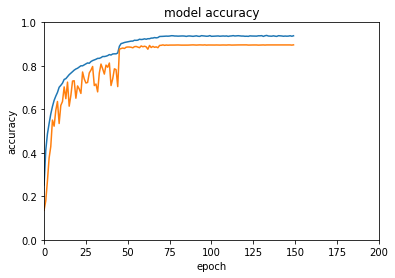

In [6]:
# Set a checkpoint to save weights
cp = tf.keras.callbacks.ModelCheckpoint("weights", monitor = "val_loss", verbose = 1, save_best_only = True, mode = "auto")
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 5, verbose = 0, 
                                          mode = 'auto', min_delta = 0.0001, cooldown = 0, min_lr = 0)
es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 20, restore_best_weights = True)

weight_decay = 1e-4
learning_rate = 5e-4
dropout = True
dropout_rate = .1

model = createResNet(34, weight_decay, dropout, dropout_rate)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])

# We can use the existing data if the training process has started
# model.load_weights("weights") 

with tf.device('/GPU:0'):
    history = model.fit(train_x, train_y, 
                        epochs = 150, validation_data = (val_x, val_y), callbacks = [lr], batch_size = 256)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim([0, 200])
plt.ylim([0, 1])
# plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig("weight_decay=" + str(weight_decay) + " lr=" + str(learning_rate) + " dropout=" + str(dropout) 
            + " dropout_rate=" + str(dropout_rate) + ".png")
plt.show()

Here we test our model on test set and show how ResNet predicts on sample images in the test set.

Test Accuracy: 88.43%


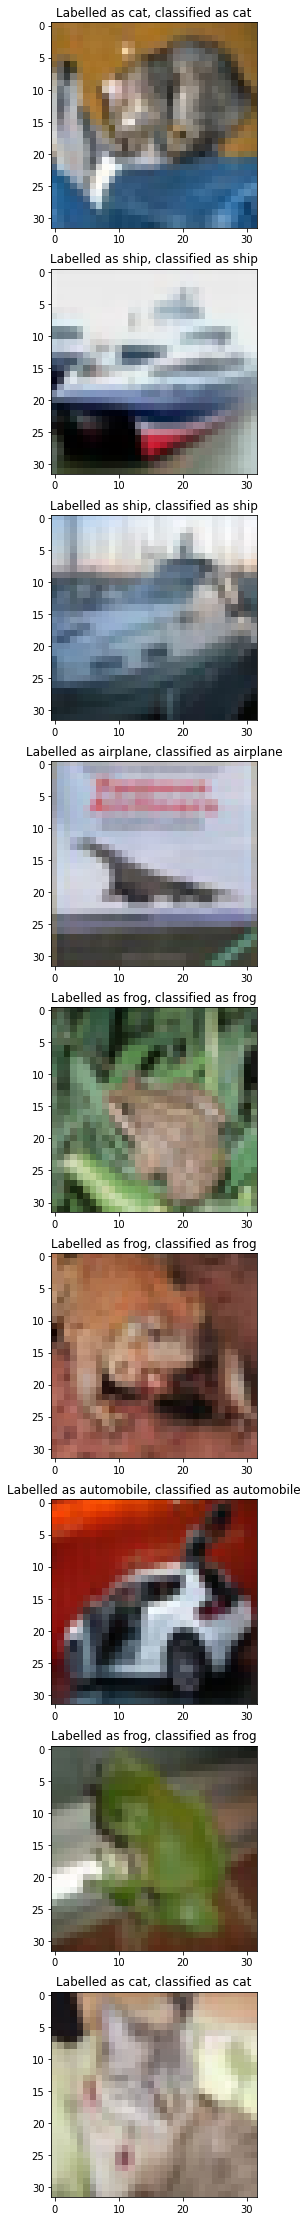

In [7]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

pred = np.argmax(model.predict(test_x), axis = 1)

print("Test Accuracy: {:.2%}".format(np.sum(pred == test_y.flatten()) / len(test_y)))

sample_data = test_x[: 9]
sample_label = test_y[: 9]

fig = plt.figure(figsize = (10, 40))

for i in range(len(sample_data)):
    ax = fig.add_subplot(911 + i)
    ax.imshow(test_x[i])

    ax.set_title("Labelled as " + labels[int(sample_label[i])] + ", classified as " + labels[int(pred[i])])